# Descripción del proyecto.

Trabajas en la compañía de extracción de petróleo OilyGiant. Tu tarea es encontrar los mejores lugares donde abrir 200 pozos nuevos de petróleo.

Para completar esta tarea, tendrás que realizar los siguientes pasos:

- Leer los archivos con los parámetros recogidos de pozos petrolíferos en la región seleccionada: calidad de crudo y volumen de reservas.
- Crear un modelo para predecir el volumen de reservas en pozos nuevos.
- Elegir los pozos petrolíferos que tienen los valores estimados más altos.
- Elegir la región con el beneficio total más alto para los pozos petrolíferos seleccionados.

Se creará un modelo que ayude a elegir la región con el mayor margen de beneficio. Analiza los beneficios y riesgos potenciales utilizando la técnica *bootstrapping*.

# Parte 1. Descargar y prerar los datos.

## 1.1 Librerías.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import bootstrap, norm


## 2.2 Carga de datos.

In [2]:
geo_data_0 = pd.read_csv("geo_data_0.csv")
geo_data_1 = pd.read_csv("geo_data_1.csv")
geo_data_2 = pd.read_csv("geo_data_2.csv")

In [3]:
print(geo_data_0.head(),"\n")
print(geo_data_1.head(),"\n")
print(geo_data_2.head())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305 

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


In [4]:
print(geo_data_0.info(),"\n")
print(geo_data_1.info(),"\n")
print(geo_data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Colu

In [5]:
print(geo_data_0.describe(include='all'),"\n")
print(geo_data_1.describe(include='all'),"\n")
print(geo_data_2.describe(include='all'))

            id             f0             f1             f2        product
count   100000  100000.000000  100000.000000  100000.000000  100000.000000
unique   99990            NaN            NaN            NaN            NaN
top      fiKDv            NaN            NaN            NaN            NaN
freq         2            NaN            NaN            NaN            NaN
mean       NaN       0.500419       0.250143       2.502647      92.500000
std        NaN       0.871832       0.504433       3.248248      44.288691
min        NaN      -1.408605      -0.848218     -12.088328       0.000000
25%        NaN      -0.072580      -0.200881       0.287748      56.497507
50%        NaN       0.502360       0.250252       2.515969      91.849972
75%        NaN       1.073581       0.700646       4.715088     128.564089
max        NaN       2.362331       1.343769      16.003790     185.364347 

            id             f0             f1             f2        product
count   100000  100000.

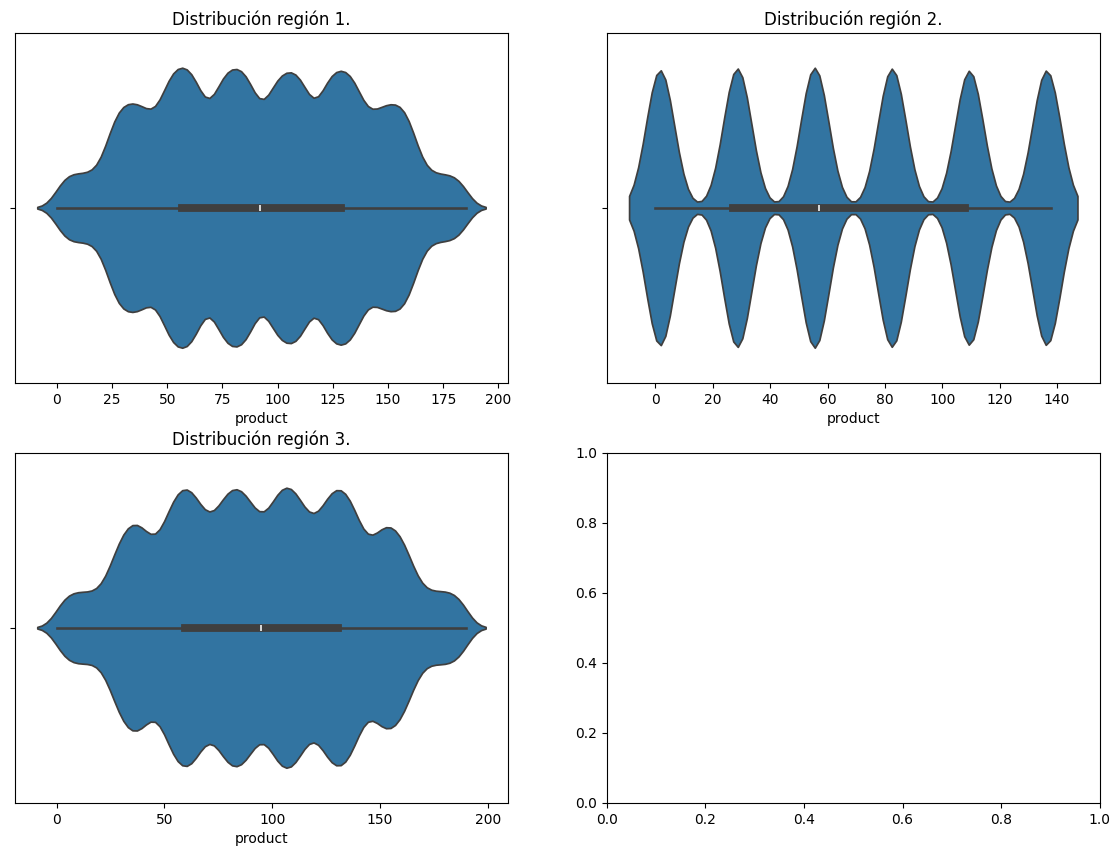

In [6]:
fig, ((ax1, ax2), (ax3, _)) = plt.subplots(2, 2)
fig.set_figwidth(14)
fig.set_figheight(10)
sns.violinplot(ax=ax1,x=geo_data_0['product'])
ax1.set_title('Distribución región 1.')
sns.violinplot(ax=ax2,x=geo_data_1['product'])
ax2.set_title('Distribución región 2.')
sns.violinplot(ax=ax3,x=geo_data_2['product'])
ax3.set_title('Distribución región 3.')
plt.show()

 Los datos se cargaron se forma existosa. Los 3 conjunto de datos no tiene ningún valor nulo y el tipo de objeto corresponde correctamente a los datos. En la descripción estadítica se obtuvo que hay 99 996 valores únicos, en cada región se repiten 2 pozos (`id`). La región 1 y 3 tiene una distribucipon de lso datos `product` de manera similar, mientras que la región 2 tiene una distribución sesgada hacia la derecha.

### 2.2.1 Revisar los datos duplicados.

El dato duplicado en la región 2 es  `fiKDv`.

In [7]:
geo_data_0.query("id == 'fiKDv'")

,id,f0,f1,f2,product
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
90815,fiKDv,0.049883,0.841313,6.394613,137.346586


El dato duplicado en la región 2 es `wt4Uk`.

In [8]:
geo_data_1.query("id == 'wt4Uk'")

,id,f0,f1,f2,product
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


Los datos duplicados en la región 3 son `VF7Jo`.

In [9]:
geo_data_2.query("id == 'VF7Jo'")

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420


A pesar de que tinen el mimso `id` en los 3 conjunto de datos, tienen diferentes registros.

# Parte 2. Entrenamiento y prueba del modelo

En este siguiente paso se entranará y se probará el modelopara cada región en el conjunto de datos `geo_data_0`. Se dividirá en el conjunto de datos en conjunto de entranmeinto y prueba en el proporción de 75:25. El modelo a entrenar será una regresión lineal y se revisará el calidad del mismo. Se colocarán los pasos previos en una función para el conjunto de datos `geo_data_1` y `geo_data_2`.

## 2.1. Dividir el conjunto de datos.

No se toma en cuenta la columna `id` para entranr el modelo debido a la acción que va tomar el modelo de aprenderse la caraterísticas de memoria.

In [10]:
X = geo_data_0[['f0','f1','f2']]
y = geo_data_0['product']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


## 2.2. Escalamiento de datos.

In [11]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=scaler.fit_transform(X_test),columns=X_test.columns)

In [12]:
print(X_train_scaled)
print(X_test_scaled)

             f0        f1        f2
0      1.274786 -0.799739 -0.396677
1     -1.600689  0.234678 -2.169283
2     -0.323791  1.436297  1.495425
3      0.439038  0.830679  0.185881
4     -1.652805  0.761012  0.111734
...         ...       ...       ...
74995  1.291452 -0.712129  0.135573
74996  1.355542 -0.882161 -1.134411
74997  0.549229 -1.591632  0.119090
74998  0.175176 -1.459344  1.429524
74999  1.029803 -1.420625 -0.149459

[75000 rows x 3 columns]
             f0        f1        f2
0      0.112101 -1.589321 -0.110233
1      0.272610 -1.402931 -1.179141
2      1.057993 -1.544522  0.382073
3      1.238912 -0.959586  0.100531
4      0.479323 -0.441815  0.036875
...         ...       ...       ...
24995  0.290564 -1.499725  0.040633
24996 -0.647567  0.530756 -0.543723
24997  0.105767 -1.328161 -0.925665
24998 -0.348606  0.406562 -0.302406
24999 -0.859695  1.509676  0.677737

[25000 rows x 3 columns]


## 2.3 Entrenamiento y calidad del modelo.

### 2.3.1. Región 1.

In [13]:
model = LinearRegression()
model.fit(X_train_scaled,y_train)
y_pred = model.predict(X_test)

In [14]:
mse = mean_squared_error(y_test,y_pred)
rmse = mse**0.5

In [15]:
print("Volumen medio de reservas predicho:", y_test.mean())
print('\nRMSE del modelo en el conjunto de prueba:', rmse)

Volumen medio de reservas predicho: 92.32595637084387

RMSE del modelo en el conjunto de prueba: 81.11662851393159


La RECM nos indica que en promedio nuetras predicciones erran por ~ 81 117 barriles. Parece mucho pero es aceptable para un modelo que siempre responde con el valor debajo de la media, dado que la región con más reservas de barriles llegan a más de 185 mil.

### 2.3.2 Preparar la función.

In [16]:
def rmse_L_Regression(data):
    features = data[['f0','f1','f2']]
    target = data['product']
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.25, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train),columns=features.columns)
    X_test_scaled = pd.DataFrame(data=scaler.fit_transform(X_test),columns=features.columns)
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = mean_squared_error(y_test,y_pred) ** 0.5
#     print("Volumen medio de reservas predicho:", y_test.mean())
#     print('\nRMSE del modelo en el conjunto de prueba:', rmse)
    return {'model':model, 'y_test_mean':y_test.mean(), 'rmse':rmse}

### 2.3.3 Región 2.

In [17]:
print(f'Volumen medio de reservas predicho {rmse_L_Regression(geo_data_1)["y_test_mean"]}')
print(f'RMSE del modelo en el conjunto de prueba: {rmse_L_Regression(geo_data_1)["rmse"]}')

Volumen medio de reservas predicho 68.72538074722745
RMSE del modelo en el conjunto de prueba: 0.8999970499802324


El RMSE indica en nuetras predicciones erran unos ~900 barriles. Bastante bien para este conjunto de datos.

### 2.3.4 Región 3

In [18]:
print(f'Volumen medio de reservas predicho {rmse_L_Regression(geo_data_2)["y_test_mean"]}')
print(f'RMSE del modelo en el conjunto de prueba: {rmse_L_Regression(geo_data_2)["rmse"]}')

Volumen medio de reservas predicho 95.15099907171961
RMSE del modelo en el conjunto de prueba: 40.1447439796432


El RMSE indica que las predicciones de la región 3 tienen en error medio de 40 mil barriles.

# Parte 3. Preparar cálculo de ganancias.

El presupuesto para el desarrollo de 200 pozos petroleros es de 100 millones de dólares. Dicho esto, de media un pozo petrolífero debe producir al menos un valor de 500,000 dólares en unidades para evitar pérdidas (esto es equivalente a 111.1 unidades). Se comparó esta cantidad con la cantidad media de reservas en cada región.

In [19]:
presupuesto = 100_000_000
cantidad_pozos = 200
ingresos_barril = 4_500
lucro_minimo_unidades = 111.1

### 3.1 Cantidad media de barriles y ganancias en cada región.

In [20]:
barril_r1_mean =  geo_data_0['product'].mean()
ingresos_r1 = barril_r1_mean * ingresos_barril
print("Región 1:\n")
print(f"Unidades de barriles producidos en promedio: {barril_r1_mean:.2f}\n")
print(f"Ganancias en USD: {ingresos_r1:.2f}")

Región 1:

Unidades de barriles producidos en promedio: 92.50

Ganancias en USD: 416250.00


In [21]:
barril_r2_mean =  geo_data_1['product'].mean()
ingresos_r2 = barril_r2_mean * ingresos_barril
print("Región 2:\n")
print(f"Unidades de barriles producidos en promedio: {barril_r2_mean:.2f}\n")
print(f"Ganancias en USD: {ingresos_r2:.2f}")

Región 2:

Unidades de barriles producidos en promedio: 68.83

Ganancias en USD: 309712.50


In [22]:
barril_r3_mean =  geo_data_2['product'].mean()
ingresos_r3 = barril_r3_mean * ingresos_barril
print("Región 3:\n")
print(f"Unidades de barriles producidos en promedio: {barril_r3_mean:.2f}\n")
print(f"Ganancias en USD: {ingresos_r3:.2f}")

Región 3:

Unidades de barriles producidos en promedio: 95.00

Ganancias en USD: 427500.00


Ninguna de las regiones llega a la unidades de 111.1 barriles o 500 000 dólares.

# Parte 4. Escribe una función para calcular la ganancia de un conjunto de pozos de petróleo seleccionados y modela las predicciones

### 4.1 Elige los 200 pozos con los valores de predicción más altos de cada una de las 3 regiones.

In [23]:
def valores_mas_altos(data):
    X = data[['f0','f1','f2']]

    prediction = pd.Series(model.predict(X))

    prediction.name = 'prediction'
    
    region = data.join(prediction)
    indice = region['prediction'].nlargest(200).index
    region_200 = region.iloc[indice,:]
    return region_200
    

In [24]:
def ganancia(data):
    print(data.iloc[valores_mas_altos(data).index,:])
    beneficio_bruto = data.iloc[valores_mas_altos(data).index,:]['product'].sum()*ingresos_barril
    print(f"Beneficio bruto: {beneficio_bruto:.2f} USD\n")
    beneficio_operativo =  beneficio_bruto - presupuesto
    return beneficio_operativo

In [25]:
print("Región 1:\n")
print(f"Benefeicio operativo: {ganancia(geo_data_0):.2f}")

Región 1:



          id        f0        f1         f2     product
51140  QFDWZ  1.092258 -0.541900  16.003790  182.079984
83095  xuWxm  1.888221  0.067384  15.428372  144.009283
51464  Fgte6  1.612452 -0.074593  15.230322  173.971897
52356  R5IYz  0.879559  0.258449  15.202838  123.920559
11404  Ue1K8  0.762994  0.742322  15.014250   76.184104
...      ...       ...       ...        ...         ...
68681  bWTHz -0.903187  0.334305  11.599498   97.704895
3806   xY7Rc  1.247499 -0.482881  11.610778  152.898337
69120  VWv23  1.330988 -0.391673  11.603801  146.261727
47527  Q76zB  0.987777  0.263655  11.599940  121.611459
58421  S8c7q  2.038708  0.350157  11.606881  144.825558

[200 rows x 5 columns]
Beneficio bruto: 127529688.28 USD

Benefeicio operativo: 27529688.28


In [26]:
print("Región 2:\n")
print(f"Benefeicio operativo: {ganancia(geo_data_1):.2f}")

Región 2:

          id         f0         f1        f2     product
26531  yLbdW -26.646255  -1.531112  5.001941  137.945408
80439  kpPCd -23.884180  -3.773158  5.001008  137.945408
55165  wcKNk -22.107811  -5.342910  5.006254  137.945408
42738  XLXvP -19.384167 -15.314765  5.010972  137.945408
20191  4zwHI -23.795133  -2.313652  4.994894  137.945408
...      ...        ...        ...       ...         ...
59793  zZzw6 -15.326874 -10.555402  5.000651  137.945408
7040   Ihs0y -17.833038  -3.304180  4.992079  137.945408
55583  DPp8p -14.515572 -15.573664  4.999820  137.945408
20775  N2baR -15.387538  -8.767971  5.002486  137.945408
58302  di4FO -13.447409  -9.078163  5.015957  137.945408

[200 rows x 5 columns]
Beneficio bruto: 124150866.97 USD

Benefeicio operativo: 24150866.97


In [27]:
print("Región 3:\n")
print(f"Beneficio operativo: {ganancia(geo_data_2):.2f}")

Región 3:

          id        f0        f1         f2     product
3540   4KBhu -2.548791  3.210600  16.739402  154.062998
98714  C6aBZ -0.209583  1.174825  16.357645   98.664401
25463  mMCBz -1.623992 -3.263073  16.313011  166.293929
6647   AaIO6  1.046668 -1.970502  16.252444  152.294162
69502  OYrnh -1.145417 -0.650543  16.223146  121.349438
...      ...       ...       ...        ...         ...
70098  JZblA -1.203156 -2.631162  12.343470  171.042469
56419  MtUK6  0.422957  0.605761  12.347223   95.073988
23998  il8vO  0.442946  0.330694  12.343233  132.242854
2981   ZTW7f -2.033913 -0.459846  12.323733  182.030007
23424  DNjtD  1.514751  0.479409  12.331792  119.627311

[200 rows x 5 columns]
Beneficio bruto: 125806406.82 USD

Beneficio operativo: 25806406.82


# Parte 5. Riesgos y ganancias de cada región.

## 5.1. Utilizando las predicciones que almacenaste en el paso 4.1, emplea la técnica del bootstrapping con 1000 muestras para hallar la distribución de los beneficios.

In [28]:
valores_mas_altos(geo_data_1)['product']

26531    137.945408
80439    137.945408
55165    137.945408
42738    137.945408
20191    137.945408
            ...    
59793    137.945408
7040     137.945408
55583    137.945408
20775    137.945408
58302    137.945408
Name: product, Length: 200, dtype: float64

In [29]:
def distribution(data,title=''):    
    
    beneficio_bruto = data.iloc[valores_mas_altos(data).index,:]['product']*ingresos_barril
    data = (beneficio_bruto - presupuesto,)

    fig, ax = plt.subplots()

    ax.hist(bootstrap(data,statistic=np.mean,n_resamples=1000,random_state=12345).bootstrap_distribution,bins=25,)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('USD.')

    fig.set_figwidth(8)
    fig.set_figheight(4)

    plt.show()

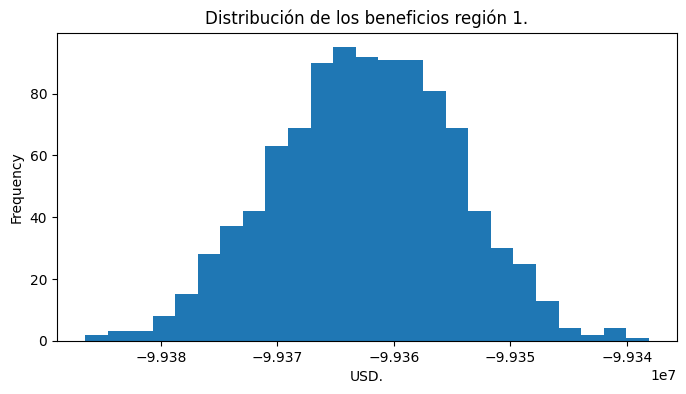

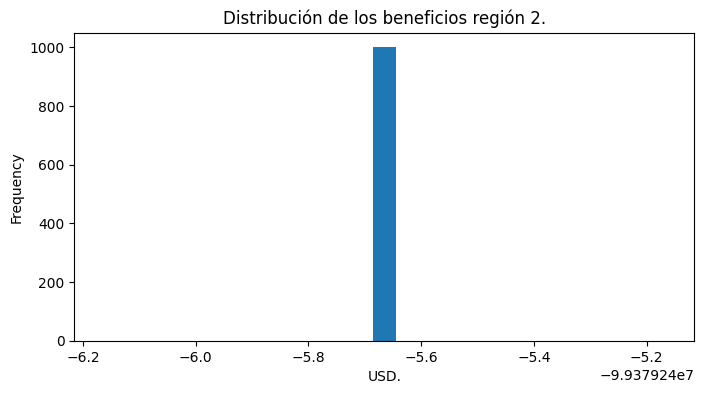

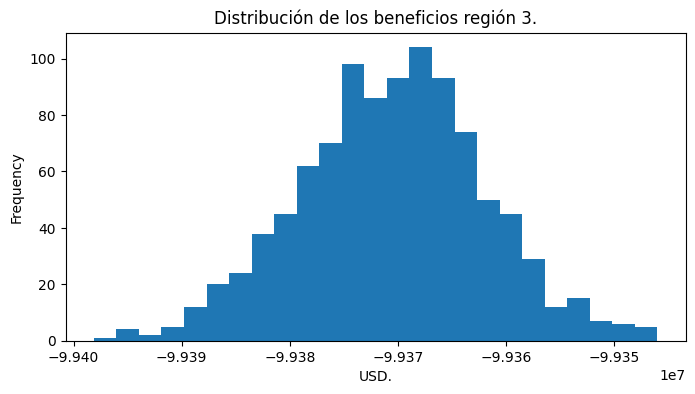

In [30]:
distribution(geo_data_0.reset_index(drop=True),'Distribución de los beneficios región 1.')

distribution(geo_data_1.reset_index(drop=True),'Distribución de los beneficios región 2.')

distribution(geo_data_2.reset_index(drop=True),'Distribución de los beneficios región 3.')

## 5.2 Encuentra el beneficio promedio, el intervalo de confianza del 95% y el riesgo de pérdidas. La pérdida es una ganancia negativa, calcúlala como una probabilidad y luego exprésala como un porcentaje.

In [31]:
def predictions(data):
    features = ['f0','f1','f2']
    predictions = pd.Series(model.predict(data[features]),name='predictions')
    data_predcitions = pd.concat([data,predictions],axis=1)
    return data_predcitions

In [32]:
predicitons_geo_data_0 = predictions(geo_data_0)
predicitons_geo_data_1 = predictions(geo_data_1)
predicitons_geo_data_2 = predictions(geo_data_2)

In [33]:
print(predicitons_geo_data_0.head(),'\n')
print(predicitons_geo_data_1.head(),'\n')
print(predicitons_geo_data_2.head(),'\n')

      id        f0        f1        f2     product  predictions
0  txEyH  0.705745 -0.497823  1.221170  105.280062   119.268829
1  2acmU  1.334711 -0.340164  4.365080   73.037750   182.013200
2  409Wp  1.022732  0.151990  1.419926   85.265647   123.177976
3  iJLyR -0.032172  0.139033  2.978566  168.620776   154.485958
4  Xdl7t  1.988431  0.155413  4.751769  154.036647   189.633802 

      id         f0         f1        f2     product  predictions
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103    97.239155
1  62mP7  14.272088  -3.475083  0.999183   26.953261   112.935195
2  vyE1P   6.263187  -5.948386  5.001160  134.766305   194.159315
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408   197.091259
4  AHL4O  12.702195  -8.147433  5.004363  134.766305   193.344197 

      id        f0        f1        f2     product  predictions
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673    78.521680
1  WJtFt  0.262778  0.269839 -2.530187   56.069697    44.331005
2  ovLUW  0.194587  0.28

In [34]:
def revenue(target, predictions):
    # Se obtienen los 200 con valores más altos
    probs_sorted = predictions.sort_values(ascending=False)[:200]
    # Se seleccionan los objetivos con base en los índices de los 200 mejores
    selected = target[probs_sorted.index]
    # Se obtiene el volumen total
    total_volume=selected.sum()
    # Se obtienen los ingresos 
    total_revenue=(total_volume*ingresos_barril)-presupuesto
    return total_revenue

In [35]:

# Función para obtener beneficio promedio, intervalo de confianza y riesgo de pérdidas
def revenue_dist(target,predictions,region):
    
    state = np.random.RandomState(16)
    
    values = []
    for i in range(1000):
        # Se obtienen las muestras del conjunto de predicciones mediante bootstrapping
        predicitions_subsample = predictions.sample(n=500,replace=True,random_state=state)
        # Se obtienen los objetivos reales con base en los indices de las predicciones seleccioandas
        target_subsample = target[predicitions_subsample.index]
        # Se añade la muestra a la lista values
        values.append(revenue(target_subsample, predicitions_subsample)) # pasemos los subsamples de target y predictions
    
    values = pd.Series(values)
    conf_interval = (values.quantile(0.025), values.quantile(0.975))
    print('El intervalo de confianza es: ',conf_interval)
    # Se obtiene el riesgo de pérdida 
    risk_of_loss=((values < 0).mean()) * 100
    print('El riesgo de pérdida es: ',risk_of_loss,'%')



In [36]:
revenue_dist(geo_data_0['product'],pd.Series(model.predict(geo_data_0[['f0','f1','f2']])),'region_1')
revenue_dist(geo_data_1['product'],pd.Series(model.predict(geo_data_1[['f0','f1','f2']])),'region_2')
revenue_dist(geo_data_2['product'],pd.Series(model.predict(geo_data_2[['f0','f1','f2']])),'region_3')

El intervalo de confianza es:  (-2389387.8506003805, 8375578.314991092)
El riesgo de pérdida es:  11.5 %
El intervalo de confianza es:  (816692.860452262, 9235984.525805188)
El riesgo de pérdida es:  1.0 %
El intervalo de confianza es:  (-1194464.1114701896, 9589634.415931353)
El riesgo de pérdida es:  6.800000000000001 %


In [37]:
revenue_dist(predicitons_geo_data_0['product'],predicitons_geo_data_0['predictions'],'region_1')
revenue_dist(predicitons_geo_data_1['product'],predicitons_geo_data_1['predictions'],'region_2')
revenue_dist(predicitons_geo_data_2['product'],predicitons_geo_data_2['predictions'],'region_3')

El intervalo de confianza es:  (-2389387.8506003805, 8375578.314991092)
El riesgo de pérdida es:  11.5 %
El intervalo de confianza es:  (816692.860452262, 9235984.525805188)
El riesgo de pérdida es:  1.0 %
El intervalo de confianza es:  (-1194464.1114701896, 9589634.415931353)
El riesgo de pérdida es:  6.800000000000001 %


In [38]:
def ROI(benefecio_operativo,inversion,data):
    return str((benefecio_operativo)/inversion * 100) + ' %'

In [39]:
print(f"Probabilidad de pérdidas en la región 1: {ROI(ganancia(geo_data_0),presupuesto,geo_data_0)}\n")
print(f"Probabilidad de pérdidas en la región 2: {ROI(ganancia(geo_data_1),presupuesto,geo_data_1)}\n")
print(f"Porbalilidad de pérdidas en la región 3: {ROI(ganancia(geo_data_2),presupuesto,geo_data_2)}")

          id        f0        f1         f2     product
51140  QFDWZ  1.092258 -0.541900  16.003790  182.079984
83095  xuWxm  1.888221  0.067384  15.428372  144.009283
51464  Fgte6  1.612452 -0.074593  15.230322  173.971897
52356  R5IYz  0.879559  0.258449  15.202838  123.920559
11404  Ue1K8  0.762994  0.742322  15.014250   76.184104
...      ...       ...       ...        ...         ...
68681  bWTHz -0.903187  0.334305  11.599498   97.704895
3806   xY7Rc  1.247499 -0.482881  11.610778  152.898337
69120  VWv23  1.330988 -0.391673  11.603801  146.261727
47527  Q76zB  0.987777  0.263655  11.599940  121.611459
58421  S8c7q  2.038708  0.350157  11.606881  144.825558

[200 rows x 5 columns]
Beneficio bruto: 127529688.28 USD

Probabilidad de pérdidas en la región 1: 27.529688284090696 %

          id         f0         f1        f2     product
26531  yLbdW -26.646255  -1.531112  5.001941  137.945408
80439  kpPCd -23.884180  -3.773158  5.001008  137.945408
55165  wcKNk -22.107811  -5.342910 

## 5.3 Presenta tus conclusiones: propón una región para el desarrollo de pozos petrolíferos y justifica tu elección. ¿Coincide tu elección con la elección anterior en el punto 4.3?

Se propone la región 3 para el desarrollo. En el paso **4.1** obtuvimos que la región con los mejores 200 pozos con menos perdida es la región 3 con el 15%. En ningún escenario se podría slavar la empresa de tener pérdidas.